In [1]:
from gnn_tracking.training.ec import ECModule
from gnn_tracking.metrics.cluster_metrics import tracking_metrics_data, \
    tracking_metric_df
from gnn_tracking.analysis.graphs import get_cc_labels

import scienceplots

import matplotlib.pyplot as plt
import numpy as np

plt.style.use(("science", "notebook"))

In [2]:
import importlib
import gnn_tracking.metrics.cluster_metrics
importlib.reload(gnn_tracking.metrics.cluster_metrics)

<module 'gnn_tracking.metrics.cluster_metrics' from '/home/kl5675/Documents/23/git_sync/gnn_tracking/src/gnn_tracking/metrics/cluster_metrics.py'>

In [3]:
from pathlib import Path
from gnn_tracking.utils.lightning import find_latest_checkpoint

# ckpt = find_latest_checkpoint(Path("/home/kl5675/Documents/23/git_sync/hyperparameter_optimization2/scripts/legacy/lightning_logs/"), "glittering-lurking-gorilla")
ckpt = "/home/kl5675/Documents/23/git_sync/hyperparameter_optimization2/scripts/legacy/lightning_logs/dexterous-earthworm-of-satiation/checkpoints_persist/epoch=42-step=309600.ckpt"

module = ECModule.load_from_checkpoint(
    ckpt,
    # map_location="cpu"
)

[19:12:39] DEBUG: Getting class EFMLP from module gnn_tracking.models.edge_filter
[19:12:39] DEBUG: Getting class HaughtyFocalLoss from module gnn_tracking.metrics.losses


In [6]:
from pytorch_lightning.utilities.model_summary import ModelSummary

ModelSummary(module)

  | Name     | Type             | Params
----------------------------------------------
0 | model    | EFMLP            | 270 K 
1 | loss_fct | HaughtyFocalLoss | 0     
----------------------------------------------
270 K     Trainable params
0         Non-trainable params
270 K     Total params
1.082     Total estimated model params size (MB)

In [4]:
ckpt

'/home/kl5675/Documents/23/git_sync/hyperparameter_optimization2/scripts/legacy/lightning_logs/dexterous-earthworm-of-satiation/checkpoints_persist/epoch=42-step=309600.ckpt'

In [5]:
from gnn_tracking.utils.loading import TrackingDataModule
dm = TrackingDataModule(
    train=dict(
        dirs=[
            "/scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/graphs_v8/part_1/"
        ],
    ),
    val=dict(
        dirs=[
            "/scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/graphs_v8/part_9/"
        ],
        stop=5
    ),
)
dm.setup(stage="fit")

[17:25:24] INFO: DataLoader will load 823 graphs (out of 823 available).
[17:25:24] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/graphs_v8/part_1/data21000_s0.pt, last graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/graphs_v8/part_1/data21999_s0.pt
[17:25:24] INFO: DataLoader will load 5 graphs (out of 959 available).
[17:25:24] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/graphs_v8/part_9/data29000_s0.pt, last graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/graphs_v8/part_9/data29004_s0.pt


In [6]:
from gnn_tracking.utils.dictionaries import add_key_suffix
from gnn_tracking.metrics.binary_classification import BinaryClassificationStats
from gnn_tracking.utils.graph_masks import get_edge_mask_from_node_mask, \
    get_good_node_mask
from tqdm import tqdm
from gnn_tracking.metrics.cluster_metrics import flatten_track_metrics
import pandas as pd

In [7]:

def _get_maximum_dm_stats(data, module, cutoffs):
    results = []
    weights = module(data)["W"]
    for cutoff in cutoffs:
        dc = data.edge_subgraph(weights > cutoff)
        y = dc.y.bool()
        ei = dc.edge_index[:, y]
        labels = get_cc_labels(ei, num_nodes=data.num_nodes)
        r= flatten_track_metrics(
            tracking_metrics_data(
                dc, labels.detach().cpu().numpy(), [0.9]
            )
        )
        r["threshold"] = cutoff
        edge_mask = get_edge_mask_from_node_mask(
            get_good_node_mask(data, pt_thld=0.9, max_eta=4), data.edge_index
        )
        bcs_thld = BinaryClassificationStats(
            output=weights[edge_mask], y=data.y[edge_mask].long(), thld=cutoff
        )
        bcs = BinaryClassificationStats(
            output=weights, y=data.y.long(), thld=cutoff
        )
        r |= add_key_suffix(bcs_thld.get_all(), "_thld")
        r |= bcs.get_all()
        results.append(r)
    return pd.DataFrame.from_records(results)


def get_maximum_dm_stats(module, dataloader, cutoffs):
    results = []
    for data in tqdm(dataloader):
        results.append(_get_maximum_dm_stats(data, module, cutoffs))
    dfs_concat = pd.concat(results)
    cols = dfs_concat.columns
    df = dfs_concat.groupby("threshold").agg(["mean", "std", "size"]).reset_index()
    for c in cols:
        if c == "threshold":
            continue
        mean = df[(c, "mean")]
        df[f"{c}_err"] = df[(c, "std")] / (df[(c, "size")] ** 0.5)
        df.drop(columns=[(c, "mean"), (c, "std"), (c, "size")], inplace=True)
        df[c] = mean
    df.columns = df.columns.get_level_values(0)
    return df

In [8]:

def _get_cc_dm_stats(data, module, cutoffs):
    results = []
    weights = module(data)["W"]
    for cutoff in cutoffs:
        dc = data.edge_subgraph(weights > cutoff)
        ei = dc.edge_index
        labels = get_cc_labels(ei, num_nodes=data.num_nodes)
        r= flatten_track_metrics(
            tracking_metrics_data(
                dc, labels.detach().cpu().numpy(), [0.9]
            )
        )
        r["threshold"] = cutoff
        results.append(r)
    return pd.DataFrame.from_records(results)


def get_cc_dm_stats(module, dataloader, cutoffs):
    results = []
    for data in tqdm(dataloader):
        results.append(_get_cc_dm_stats(data, module, cutoffs))
    dfs_concat = pd.concat(results)
    cols = dfs_concat.columns
    df = dfs_concat.groupby("threshold").agg(["mean", "std", "size"]).reset_index()
    for c in cols:
        if c == "threshold":
            continue
        mean = df[(c, "mean")]
        df[f"{c}_err"] = df[(c, "std")] / (df[(c, "size")] ** 0.5)
        df.drop(columns=[(c, "mean"), (c, "std"), (c, "size")], inplace=True)
        df[c] = mean
    df.columns = df.columns.get_level_values(0)
    return df

def get_cc_details(module, dataloader, cutoff):
    h_dfs = []
    c_dfs = []
    for data in tqdm(dataloader):
        weights = module(data)["W"]
        dc = data.edge_subgraph(weights > cutoff)
        ei = dc.edge_index
        labels = get_cc_labels(ei, num_nodes=data.num_nodes)
        h_df = pd.DataFrame(
            {
                "c": labels,
                "id":data.particle_id,
                "reconstructable": data.reconstructable,
                "pt": data.pt,
                "eta": data.eta,
            }
        )
        c_df = tracking_metric_df(h_df)
        h_dfs.append(h_df)
        c_dfs.append(c_df)
    return h_dfs, c_dfs

In [9]:
data = dm.datasets["val"][0]
w = module(data)["W"].detach().numpy()

In [11]:
y = data.y.bool().detach().numpy()

(array([ 255.,   69.,   70.,   78.,   83.,   84.,   78.,   82.,  104.,
          81.,  102.,  104.,   92.,   84.,   81.,   83.,  111.,   99.,
          96.,   93.,   99.,  103.,   88.,   97.,  105.,   87.,  104.,
         120.,  117.,  121.,  105.,   89.,   96.,  123.,   98.,  112.,
         107.,  132.,  106.,  136.,  104.,  123.,  125.,  127.,  113.,
         131.,  143.,  120.,  135.,  140.,  137.,  130.,  146.,  121.,
         138.,  147.,  165.,  168.,  172.,  171.,  191.,  167.,  200.,
         166.,  180.,  203.,  211.,  223.,  220.,  233.,  264.,  233.,
         287.,  274.,  310.,  307.,  319.,  374.,  394.,  417.,  431.,
         404.,  524.,  603.,  589.,  739.,  783.,  830.,  924., 1081.,
        1129., 1081., 1081.,  927.,  774.,  494.,  300.,  140.,   35.,
          10.]),
 array([0.001     , 0.01086508, 0.02073017, 0.03059525, 0.04046034,
        0.05032542, 0.06019051, 0.0700556 , 0.07992068, 0.08978576,
        0.09965084, 0.10951594, 0.11938102, 0.1292461 , 0.13911119

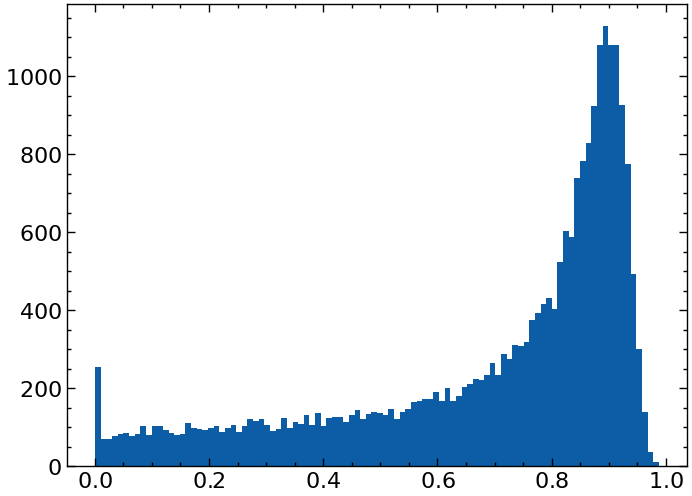

In [12]:
plt.hist(w[y & (data.pt[data.edge_index[0]] > 0.9).detach().numpy()], bins=100)

In [22]:
print('test')

test


In [23]:

thlds = [0] + np.logspace(-5, -1, 101).tolist() + np.linspace(0.1, 1, 51).tolist()
df = get_maximum_dm_stats(module, dm.val_dataloader(), thlds)

  0%|                                                                                                                                                                                                                        | 0/5 [00:00<?, ?it/s]/scratch/gpfs/kl5675/micromamba/envs/gnn/lib/python3.10/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [10:21<00:00, 124.32s/it]


In [29]:
thlds = [0] + np.logspace(-5, -1, 21).tolist() + np.linspace(0.1, 1, 31).tolist()
dfcc = get_cc_dm_stats(module, dm.val_dataloader(), thlds)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [15:34<00:00, 186.93s/it]


In [30]:
df.to_csv("df.csv")
dfcc.to_csv("dfcc.csv")

In [35]:
dfcc_dm_max_idx = dfcc["double_majority_pt0.9"].argmax()
dfcc_dm_max_thld = dfcc.loc[dfcc_dm_max_idx]["threshold"]

In [36]:
dfcc.loc[dfcc_dm_max_idx]

threshold                            0.310000
n_particles_pt0.9_err               55.594964
n_particles_pt0.9                 1404.000000
n_cleaned_clusters_pt0.9_err        42.312410
n_cleaned_clusters_pt0.9          1256.800000
perfect_pt0.9_err                    0.006279
perfect_pt0.9                        0.411449
double_majority_pt0.9_err            0.007900
double_majority_pt0.9                0.788887
lhc_pt0.9_err                        0.008533
lhc_pt0.9                            0.771271
fake_perfect_pt0.9_err               0.005698
fake_perfect_pt0.9                   0.484617
fake_double_majority_pt0.9_err       0.003730
fake_double_majority_pt0.9           0.107179
fake_lhc_pt0.9_err                   0.008533
fake_lhc_pt0.9                       0.228729
Name: 29, dtype: float64

In [41]:
cc_h_dfs, cc_c_dfs = get_cc_details(module, dm.val_dataloader(), dfcc_dm_max_thld)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:26<00:00, 29.21s/it]


In [42]:
import pickle

with Path("cc_h_dfs.pkl").open("wb") as f:
    pickle.dump(cc_h_dfs, f)
with Path("cc_c_dfs.pkl").open("wb") as f:
    pickle.dump(cc_c_dfs, f)

In [51]:
from gnn_tracking.metrics.cluster_metrics import tracking_metrics_vs_eta

etas = np.array(np.linspace(-4, 4, 20).tolist() + [4.0])
vs_eta_cc = tracking_metrics_vs_eta(cc_h_dfs, cc_c_dfs, etas=etas)
vs_eta_cc.to_csv("vs_eta_cc.csv")

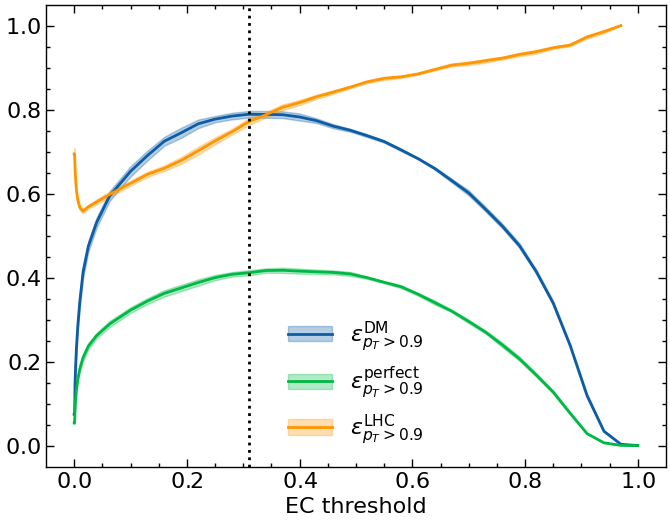

In [37]:
class CCPlot:
    def __init__(self, df: pd.DataFrame):
        self.df = df
        self._legend_items = []
        self.fig, ax = plt.subplots()
        ax.set_xlabel("EC threshold")
        self.ax = ax

    def plot_errorline(self, key, label="", ax=None, **kwargs):
        if ax is None:
            ax = self.ax
        line, *_ = ax.plot(
            self.df.threshold,
            self.df[key],
            **kwargs,
        )
        color = line.get_color()
        shading = ax.fill_between(
            self.df.threshold,
            self.df[key] - self.df[f"{key}_err"],
            self.df[key] + self.df[f"{key}_err"],
            color=color,
            alpha=0.3,
        )
        self._legend_items.append(((line, shading), label))
        return color

    def plot_dm(self):
        self.plot_errorline(
            "double_majority_pt0.9",
            label=r"$\epsilon^{\mathrm{DM}}_{p_T > 0.9}$",
        )

    def plot_perfect(self):
        self.plot_errorline(
            "perfect_pt0.9",
            label="$\epsilon^{\mathrm{perfect}}_{p_T > 0.9}$",
        )

    def plot_lhc(self):
        self.plot_errorline(
            "lhc_pt0.9",
            label="$\epsilon^{\mathrm{LHC}}_{p_T > 0.9}$",
        )

    def add_legend(self, **kwargs):
        all_handles = [item[0] for item in self._legend_items]
        all_labels = [item[1] for item in self._legend_items]
        self.ax.legend(all_handles, all_labels, **kwargs)


ccp = CCPlot(dfcc)
ccp.plot_dm()
ccp.plot_perfect()
ccp.plot_lhc()
ccp.add_legend()
ccp.ax.axvline(dfcc_dm_max_thld, color="black", ls=":")
ccp.ax.get_figure().savefig("ccp.pdf")

In [156]:
dfcc_max_dm = dfcc["double_majority_pt0.9"].max()

In [159]:
dfcc[dfcc["double_majority_pt0.9"] == dfcc_max_dm][["perfect_pt0.9"]]

,perfect_pt0.9
16,0.417143


In [115]:
df

,threshold,n_particles_pt0.9_err,n_particles_pt0.9,n_cleaned_clusters_pt0.9_err,n_cleaned_clusters_pt0.9,perfect_pt0.9_err,perfect_pt0.9,double_majority_pt0.9_err,double_majority_pt0.9,lhc_pt0.9_err,...,MCC_err,MCC,n_true_err,n_true,n_false_err,n_false,n_predicted_true_err,n_predicted_true,n_predicted_false_err,n_predicted_false
0,0.000000,55.594964,1404.0,53.470927,1416.8,0.002432,0.953908,0.001472,0.987096,0.0,...,0.000000,0.000000,4683.525424,129916.0,202446.448941,2803300.4,207109.687892,2933216.4,0.000000,0.0
1,0.000010,55.594964,1404.0,53.470927,1416.8,0.002432,0.953908,0.001472,0.987096,0.0,...,0.000000,0.000000,4683.525424,129916.0,202446.448941,2803300.4,207109.687892,2933216.4,0.000000,0.0
2,0.000011,55.594964,1404.0,53.470927,1416.8,0.002432,0.953908,0.001472,0.987096,0.0,...,0.000000,0.000000,4683.525424,129916.0,202446.448941,2803300.4,207109.687892,2933216.4,0.000000,0.0
3,0.000012,55.594964,1404.0,53.470927,1416.8,0.002432,0.953908,0.001472,0.987096,0.0,...,0.000000,0.000000,4683.525424,129916.0,202446.448941,2803300.4,207109.687892,2933216.4,0.000000,0.0
4,0.000013,55.594964,1404.0,53.470927,1416.8,0.002432,0.953908,0.001472,0.987096,0.0,...,0.000000,0.000000,4683.525424,129916.0,202446.448941,2803300.4,207109.687892,2933216.4,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,0.928000,55.594964,1404.0,8.298193,174.6,0.000496,0.013575,0.000976,0.058810,0.0,...,0.002867,0.122841,4683.525424,129916.0,202446.448941,2803300.4,161.557606,2229.6,206973.686418,2930986.8
149,0.946000,55.594964,1404.0,1.593738,76.8,0.000472,0.004089,0.001090,0.023527,0.0,...,0.002095,0.071374,4683.525424,129916.0,202446.448941,2803300.4,58.820575,744.4,207066.720415,2932472.0
150,0.964000,55.594964,1404.0,1.854724,14.2,0.000244,0.000819,0.000280,0.004835,0.0,...,0.001849,0.027821,4683.525424,129916.0,202446.448941,2803300.4,12.792185,108.8,207114.301773,2933107.6
151,0.982000,55.594964,1404.0,0.509902,1.4,0.000141,0.000141,0.000178,0.000431,0.0,...,0.001850,0.008426,4683.525424,129916.0,202446.448941,2803300.4,4.505552,11.0,207112.789968,2933205.4


In [75]:
from ocpaper231.names import variable_manager as vm

In [76]:
print("test")

test


In [108]:
import matplotlib.pyplot as plt

class ThresholdPossibilityInfoPlot:
    def __init__(self, df: pd.DataFrame):
        self.df = df
        self._legend_items = []
        self.fig, ax = plt.subplots()
        ax.set_xlabel("EC threshold")
        self.ax = ax
        self.log_ax = ax.twinx()
        self.log_ax.set_yscale("log")
        self.log_ax.set_ylabel("FPR", color="C3")
        self.log_ax.tick_params(axis='y', labelcolor="C3")

    def plot(self):
        self.plot_dm()
        self.plot_perfect()
        self.plot_tpr_fpr()

    def plot_errorline(self, key, label="", ax=None, **kwargs):
        if ax is None:
            ax = self.ax
        line, *_ = ax.plot(
            self.df.threshold,
            self.df[key],
            **kwargs,
        )
        color = line.get_color()
        shading = ax.fill_between(
            self.df.threshold,
            self.df[key] - self.df[f"{key}_err"],
            self.df[key] + self.df[f"{key}_err"],
            color=color,
            alpha=0.3,
        )
        self._legend_items.append(((line, shading), label))
        return color

    def plot_dm(self):
        self.plot_errorline(
            "double_majority_pt0.9",
            label=r"Upper bound on $\epsilon^{\mathrm{DM}}_{p_T > 0.9}$",
        )

    def plot_perfect(self):
        self.plot_errorline(
            "perfect_pt0.9",
            label="Upper bound on $\epsilon^{\mathrm{perfect}}_{p_T > 0.9}$",
        )

    def plot_tpr_fpr(self):
        self.plot_errorline(
            "TPR_thld",
            label=r"TPR (tracks of interest)",
            ls = "--",
        )
        self.plot_errorline(
            "FPR",
            label="FPR (log scale)",
            ls="--",
            ax=self.log_ax,
            color="C3"
        )

    def add_legend(self, **kwargs):
        all_handles = [item[0] for item in self._legend_items]
        all_labels = [item[1] for item in self._legend_items]
        self.ax.legend(all_handles, all_labels, **kwargs)


In [154]:
!pwd

/home/kl5675/Documents/23/git_sync/hyperparameter_optimization2/scripts/legacy


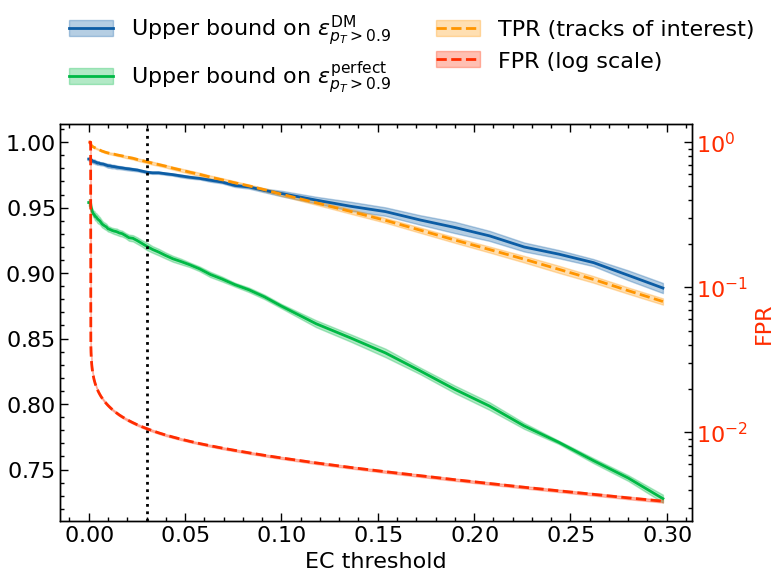

In [ ]:
tpip = ThresholdPossibilityInfoPlot(df.query("threshold < 0.3"))
tpip.plot()
tpip.add_legend(loc=(0, 1.05), ncols=2)
tpip.ax.get_figure().tight_layout()
tpip.ax.get_figure().savefig("tpip.pdf")

In [149]:
atpoint = get_maximum_dm_stats(module, dm.val_dataloader(), [0.03])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [06:05<00:00, 73.10s/it]


In [155]:
atpoint[["TPR", "TPR_thld", "FPR", "double_majority_pt0.9", "perfect_pt0.9"]]

,TPR,TPR_thld,FPR,double_majority_pt0.9,perfect_pt0.9
0,0.482749,0.985146,0.010605,0.977064,0.920599


In [147]:
for col in ["TPR", "TPR_thld", "FPR", "double_majority_pt0.9", "perfect_pt0.9"]:
    print(col, this_df[col].item())

ValueError: can only convert an array of size 1 to a Python scalar

In [26]:
for col in ["TPR", "TPR_thld", "FPR", "double_majority_pt0.9", "perfect_pt0.9"]:
    print(col, this_df[col].item())

TPR 0.482748844270631
TPR_thld 0.9851460478361769
FPR 0.010604656149215894
double_majority_pt0.9 0.9770644089375089
perfect_pt0.9 0.9205989587496509


In [86]:
fpr_thld_cut = this_df["FPR"].item()

In [116]:
from scipy.integrate import simpson, trapezoid

default_roc_auc = -trapezoid(df["TPR"], x=df["FPR"])
interest_roc_auc = -trapezoid(df["TPR_thld"], x=df["FPR"])

In [117]:
default_roc_auc, interest_roc_auc

(0.9329238117333906, 0.9976406431890691)

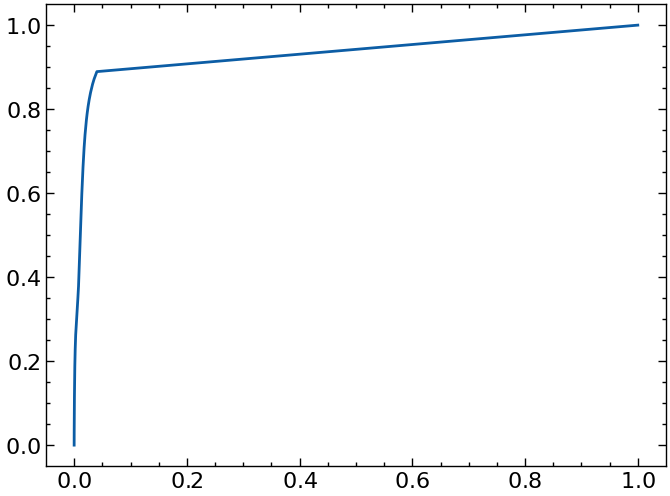

In [111]:
plt.plot(df["FPR"], df["TPR"])

In [113]:
# def get_bcs_stats(model, dataloader, thresholds):
#     for data in dataloader:
#         weights = model(data)["W"]
#         edge_mask = get_edge_mask_from_node_mask(
#             get_good_node_mask(data, pt_thld=0.9, max_eta=4), data.edge_index
#         )
#         y = data.y.long()
#         y_masked = data.y[edge_mask].long()
#         weights_masked = weights[edge_mask]
#         results = []
#         for cutoff in thresholds:
#             r = {}
#             r["threshold"] = cutoff
#             bcs_thld = BinaryClassificationStats(
#                 output=weights_masked, y=y_masked, thld=cutoff
#             )
#             bcs = BinaryClassificationStats(
#                 output=weights, y=y, thld=cutoff
#             )
#             r |= add_key_suffix(bcs_thld.get_all(), "_thld")
#             r |= bcs.get_all()
#             results.append(r)
#     dfs_concat = pd.concat(results)
#     cols = dfs_concat.columns
#     df = dfs_concat.groupby("threshold").agg(["mean", "std", "size"]).reset_index()
#     for c in cols:
#         if c == "threshold":
#             continue
#         mean = df[(c, "mean")]
#         df[f"{c}_err"] = df[(c, "std")] / (df[(c, "size")] ** 0.5)
#         df.drop(columns=[(c, "mean"), (c, "std"), (c, "size")], inplace=True)
#         df[c] = mean
#     df.columns = df.columns.get_level_values(0)
#     return df

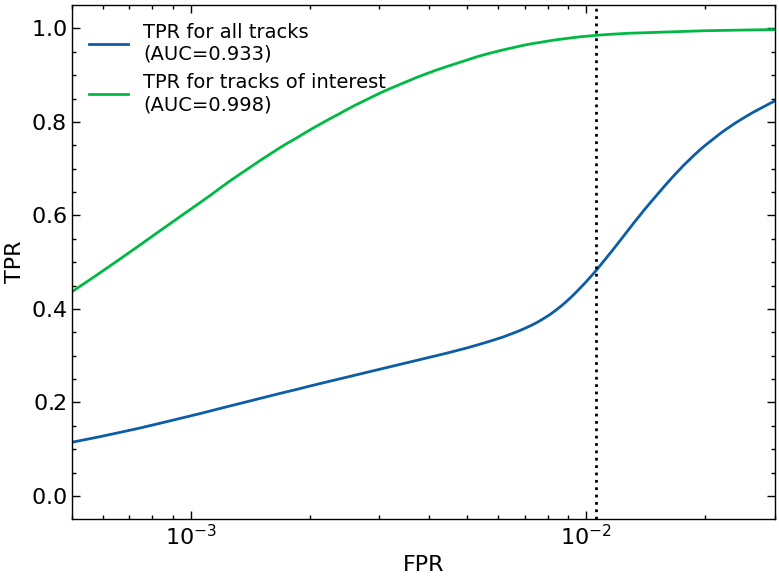

In [132]:
fig, ax = plt.subplots()
ax.set_xlim(0.0005, 0.03)
ax.plot("FPR", "TPR", data=df, label=f"TPR for all tracks\n(AUC={default_roc_auc:.3f})")
ax.plot("FPR", "TPR_thld", data=df, label=f"TPR for tracks of interest\n(AUC={interest_roc_auc:.3f})")
ax.set_xscale("log")
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")
ax.axvline(fpr_thld_cut, c="k", ls=":")
ax.legend(loc="upper left", ncols=1,  fontsize=14)
fig.tight_layout()
fig.savefig("ef_roc.pdf")

In [150]:
!pwd

/home/kl5675/Documents/23/git_sync/hyperparameter_optimization2/scripts/legacy
